# Siikaneva Fen Data from Download 
Data are downloaded as half hourly. Here I will aggregate that dataset to the daily time scale (using averages, to avoid filling gaps, but with an NaN if > 25% of the data is missing for the day, and a flag if 10%+ is missing). After aggregating, the data will be checked for outliers and strange values. 

To get an ET dataset to use as a possible control on gas fluxes, negative values (dew fall) for the H20 vapor flux will be set to zero. However, when H20 vaport is used as a sink, use the dataset WITH the negative values.
   

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import copy
np.random.seed(50)
import pylab


In [2]:
# Load in the data table
table = pd.read_csv('smeardata_H2OCO2.csv', header=0)
table = table.drop(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second'], axis=1);
dates = pd.date_range(start='1/1/2005', end='1/1/2015', freq='30min')
dates = dates[0:-1]
table['Datetime'] = dates
table = table.set_index(['Datetime'])
# Add in a column for T-normalized methane flux
#table['CH4/T'] = table['methane_flux']/table['T_air']

In [3]:
table.head(5)

,SII1_EDDY.F_H2O_LI70,SII1_EDDY.F_H2O_PIC,SII1_EDDY.F_c_LI70,SII1_EDDY.Qc_CO2_LI70,SII1_EDDY.F_c_LI72,SII1_EDDY.Qc_CO2_LI72
Datetime,,,,,,
2005-01-01 00:00:00,-0.070555,NaN,0.099347,2.0,NaN,NaN
2005-01-01 00:30:00,-0.044799,NaN,0.048567,2.0,NaN,NaN
2005-01-01 01:00:00,-0.046979,NaN,0.096897,2.0,NaN,NaN
2005-01-01 01:30:00,-0.033805,NaN,0.088506,2.0,NaN,NaN
2005-01-01 02:00:00,0.014160,NaN,0.118076,2.0,NaN,NaN


# Generate time series plots

### Look at water vapor data

<IPython.core.display.Javascript object>


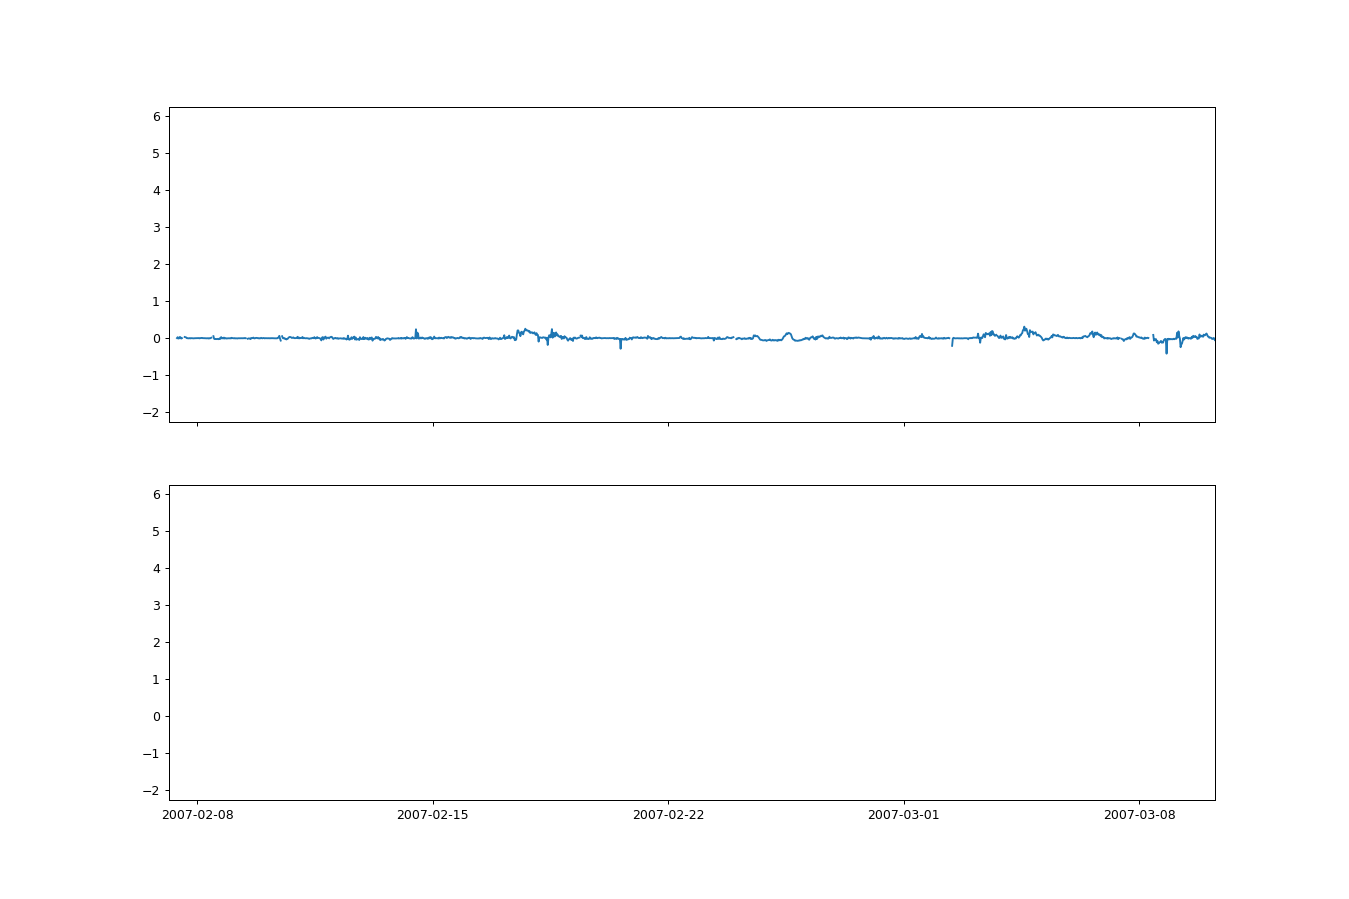

<IPython.core.display.Javascript object>


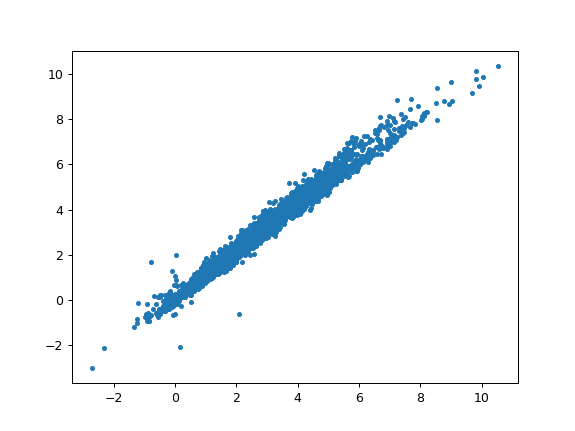

In [4]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize = [15,10])
axs[0].plot(table['SII1_EDDY.F_H2O_LI70'])
axs[1].plot(table['SII1_EDDY.F_H2O_PIC'])
plt.figure()
plt.plot(table['SII1_EDDY.F_H2O_LI70'], table['SII1_EDDY.F_H2O_PIC'], '.')

I will just use the Licor data record, as it is more complete. It looks like at least two outliers will need to be removed. 

Text(0,0.5,'SII1_EDDY.F_H2O_LI70')

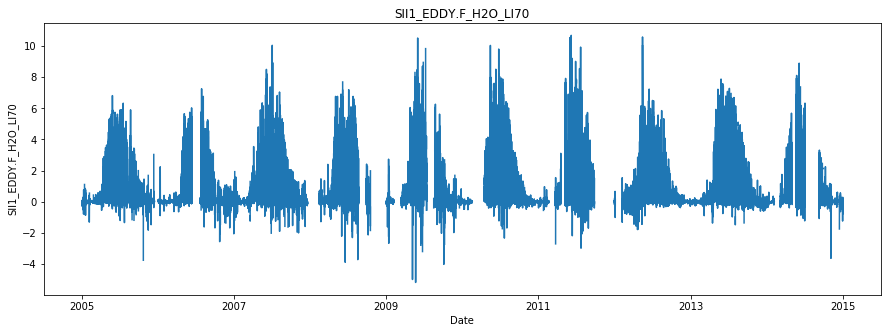

In [3]:
table.loc[table['SII1_EDDY.F_H2O_LI70'] < -10, 'SII1_EDDY.F_H2O_LI70'] = np.nan
table.loc[table['SII1_EDDY.F_H2O_LI70'] > 15, 'SII1_EDDY.F_H2O_LI70'] = np.nan
plt.figure(figsize=[15,5])
plt.plot(table['SII1_EDDY.F_H2O_LI70'])
plt.title('SII1_EDDY.F_H2O_LI70')
plt.xlabel('Date')
plt.ylabel('SII1_EDDY.F_H2O_LI70')

### Now look at the CO_2 data

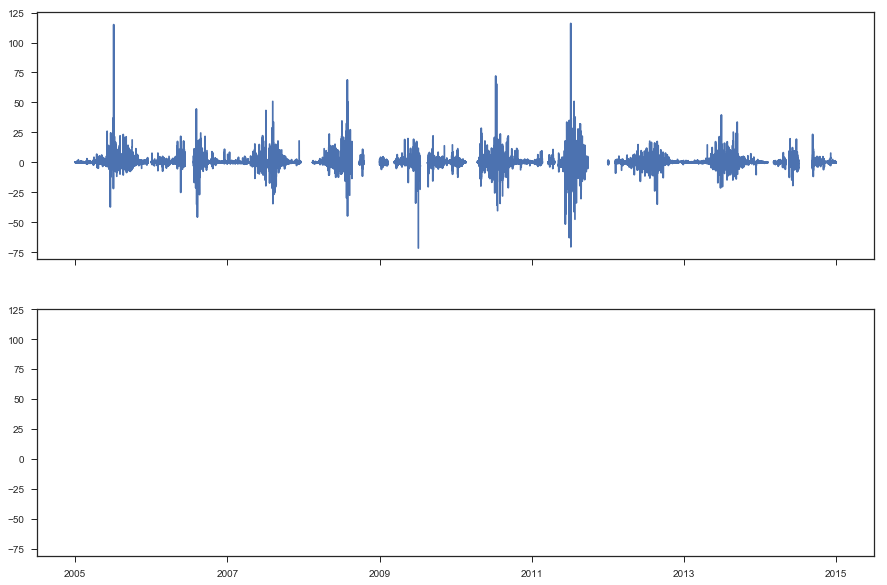

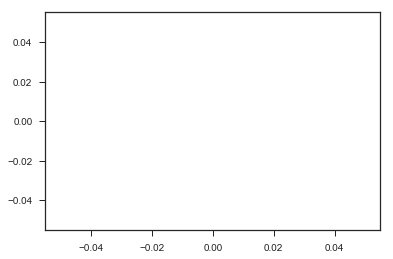

In [61]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize = [15,10])
axs[0].plot(table['SII1_EDDY.F_c_LI70'])
axs[1].plot(table['SII1_EDDY.F_c_LI72'])
plt.figure()
plt.plot(table['SII1_EDDY.F_c_LI70'], table['SII1_EDDY.F_c_LI72'], '.')

OK! So there is only data from the LiCor 170 for this time period. Color by quality.

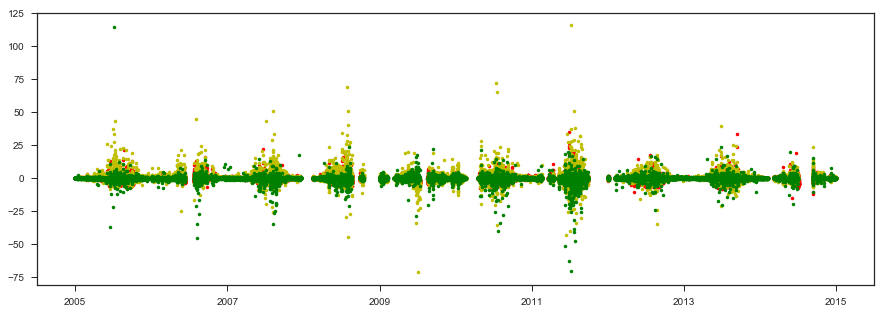

In [78]:
plt.figure(figsize=[15,5])
plt.plot(table.loc[table['SII1_EDDY.Qc_CO2_LI70'] == 0, 'SII1_EDDY.F_c_LI70'], 'r.')
plt.plot(table.loc[table['SII1_EDDY.Qc_CO2_LI70'] == 1, 'SII1_EDDY.F_c_LI70'], 'y.')
plt.plot(table.loc[table['SII1_EDDY.Qc_CO2_LI70'] == 2, 'SII1_EDDY.F_c_LI70'], 'g.')

None of the spikes have quality 0. I guess that is a good thing?

## Gap fill

Let's fill small gaps so that we can reasonably aggregate to the daily scale. First, we will see if the other sensor has data and use that if available. Then, following Rinne (see email), we will only fill gaps of 8 hours or less. 

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


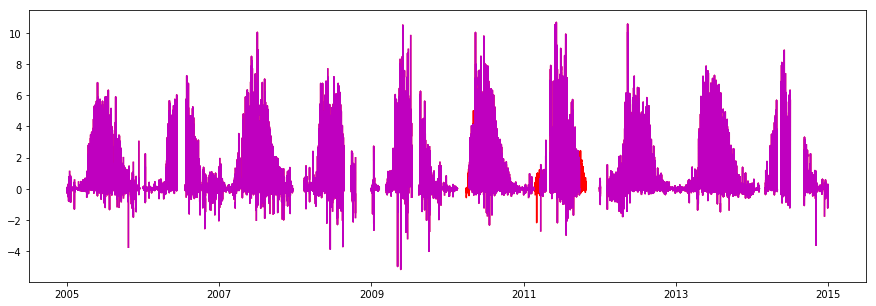

In [8]:
table['H2O_gapfilled']=copy.deepcopy(table['SII1_EDDY.F_H2O_LI70'])
cond1 = np.isnan(table['SII1_EDDY.F_H2O_LI70'])
cond2 = ~np.isnan(table['SII1_EDDY.F_H2O_PIC'])
table['H2O_gapfilled'][np.transpose(np.where((cond1) & (cond2)))] = table['SII1_EDDY.F_H2O_PIC'][np.transpose(np.where((cond1) & (cond2)))]
table.head()
plt.figure(figsize=[15,5])
plt.plot(table['H2O_gapfilled'], 'r')
plt.plot(table['SII1_EDDY.F_H2O_LI70'], 'm')
#np.where((a > 2) & (a < 6), -1, 100)

Gapfilled with the other sensor depicted in the plot above (in red). Now flag the remaining NaNs (these data are truly missing) and fill gaps less than 8 hours through time interpolation.

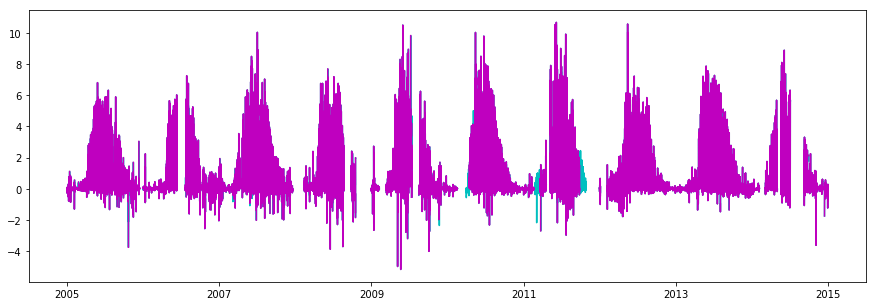

In [9]:
table['GapFlag']= np.isnan(table['H2O_gapfilled']) #flag the gaps
table['H2O_gapfilled']=table['H2O_gapfilled'].interpolate(method='time', limit = 16, limit_area='inside')
plt.figure(figsize=[15,5])
plt.plot(table['H2O_gapfilled'], 'c')
plt.plot(table['SII1_EDDY.F_H2O_LI70'], 'm')

## Aggregate time series to daily data

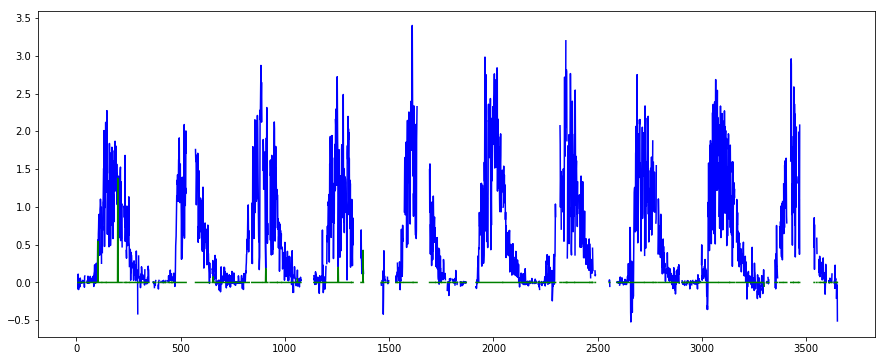

In [54]:
#Reshape so that all values in a day are in the rows and each day is a different column.
#CO2_flux_day_block = table['SII1_EDDY.F_c_LI70'].values.reshape(48,-1, order='F') #The "-1" calculates what that dimension should be from the size of the original array
H2O_flux_day_block = table['H2O_gapfilled'].values.reshape(48,-1, order='F')
H2O_flag_day_block = table['GapFlag'].values.reshape(48,-1,order='F')

#CO2_valid_entries = np.sum(~np.isnan(CO2_flux_day_block), axis=0) # Number of valid readings in a day
H2O_flags = np.sum(H2O_flag_day_block, axis=0)

#plt.figure(figsize=[15,5])
#plt.plot(CO2_valid_entries)
#plt.figure(figsize=[15,5])
#plt.plot(H2O_valid_entries)

#CO2_daily = np.nanmean(CO2_flux_day_block, axis=0)
H2O_daily = np.mean(H2O_flux_day_block, axis=0)

#There may be multiple blocks within a day that were filled, totaling 8 hours or more. We need to get rid of these.
H2O_daily[H2O_flags>15]=np.nan

#plt.figure(1, figsize=[15,5])
#plt.plot(CO2_daily, 'r')
plt.figure(figsize=[15,6])
plt.plot(H2O_daily, 'b')
plt.plot(H2O_daily*(H2O_flags>14), 'g')

#Now remove datapoints that don't meet criteria of > 75% of datapoints within the day valid
#CO2_daily[CO2_valid_entries < 36] = np.nan
#H2O_daily[H2O_valid_entries < 36] = np.nan

#Flag datapoints where > 10% of entries within the day are invalid. 1 is the flag.
#flag_CO2 = np.zeros(len(CO2_daily))
##flag_H2O = np.zeros(len(H2O_daily))
#flag_CO2[CO2_valid_entries<=41] = 1 #43
#flag_H2O[H2O_valid_entries<=41] = 1 
#flag_CO2[CO2_valid_entries<36] = 0
#flag_H2O[H2O_valid_entries<36] = 0

#plt.figure(1)
#plt.plot(CO2_daily)
#plt.plot(CO2_daily*flag_CO2, 'y')
#plt.figure(2)
#plt.plot(H2O_daily)
#plt.plot(H2O_daily*flag_H2O, 'y')

## Plot histograms of data

Text(0.5,1,'sqrt(H2O Daily)')

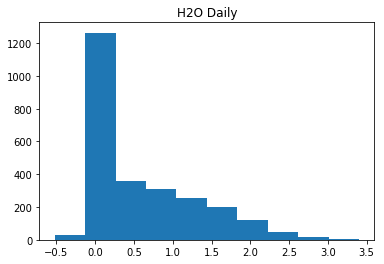

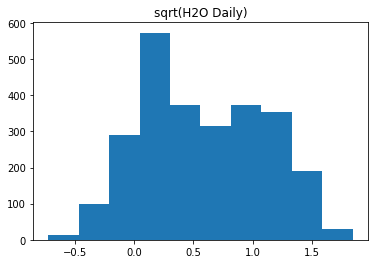

In [59]:
pylab.figure()
pylab.hist((H2O_daily[~np.isnan(H2O_daily)]))
    #pylab.show()
pylab.title('H2O Daily')
pylab.figure()
pylab.hist((np.sign(H2O_daily[~np.isnan(H2O_daily)])*np.sqrt(np.abs(H2O_daily[~np.isnan(H2O_daily)]))))
    #pylab.show()
pylab.title('sqrt(H2O Daily)')
#pylab.figure()
#pylab.hist(table.GPP[~np.isnan(table.GPP)])
#pylab.show()

In [64]:
#Export to CSV

df = pd.DataFrame(H2O_daily)
df.to_csv('Cleaned_Daily_H2OF.csv', sep=',')